# 1. Initial Setup

In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from datetime import datetime

# Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [212]:
# Load cleaned data
df = pd.read_csv('../data/processed/tesla_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')  # Ensure time order

# Overview
display(df.head(5))
print(df.info())
display(df.describe())
print("Null values:\n", df.isnull().sum())

,Date,Close/Last,Volume,Open,High,Low
0,2024-09-06,210.73,112177000.0,232.60,233.6000,210.51
1,2024-09-05,230.17,119355000.0,223.49,235.0000,222.25
2,2024-09-04,219.41,80651770.0,210.59,222.2200,210.57
3,2024-09-03,210.60,76714220.0,215.26,219.9043,209.64
4,2024-08-30,214.11,63370610.0,208.63,214.5701,207.03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        252 non-null    datetime64[ns]
 1   Close/Last  252 non-null    float64       
 2   Volume      252 non-null    float64       
 3   Open        252 non-null    float64       
 4   High        252 non-null    float64       
 5   Low         252 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB
None


,Date,Close/Last,Volume,Open,High,Low
count,252,252.000000,2.520000e+02,252.000000,252.000000,252.000000
mean,2024-03-07 09:02:51.428571392,210.513770,1.046642e+08,210.568929,214.852217,206.311039
min,2023-09-07 00:00:00,142.050000,5.086968e+07,140.560000,144.440000,138.802500
25%,2023-12-05 18:00:00,180.005000,8.277002e+07,181.950000,184.505000,176.980000
50%,2024-03-07 12:00:00,208.970000,1.037052e+08,210.015000,214.845000,205.775000
75%,2024-06-06 06:00:00,239.825000,1.211449e+08,239.340000,245.232500,235.000075
max,2024-09-06 00:00:00,276.040000,2.438697e+08,277.550000,278.980000,271.000000
std,NaN,32.394141,3.002907e+07,32.434372,33.049391,31.808199


Null values:
 Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


# 2. Univariate Analysis

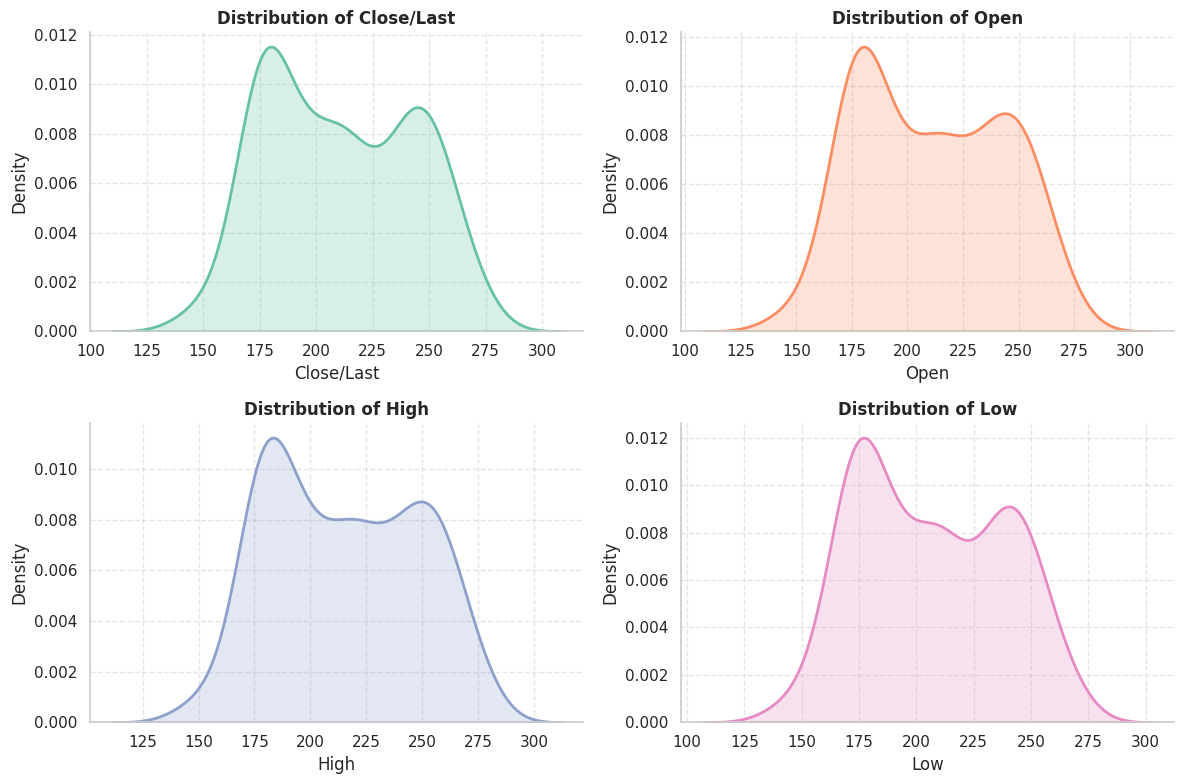

In [213]:
# Price Distributions
price_cols = ['Close/Last', 'Open', 'High', 'Low']
palette = sns.color_palette("Set2", len(price_cols))  # Colorful and distinct

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(price_cols):
    sns.kdeplot(df[col], fill=True, color=palette[i], ax=axes[i], linewidth=2)
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

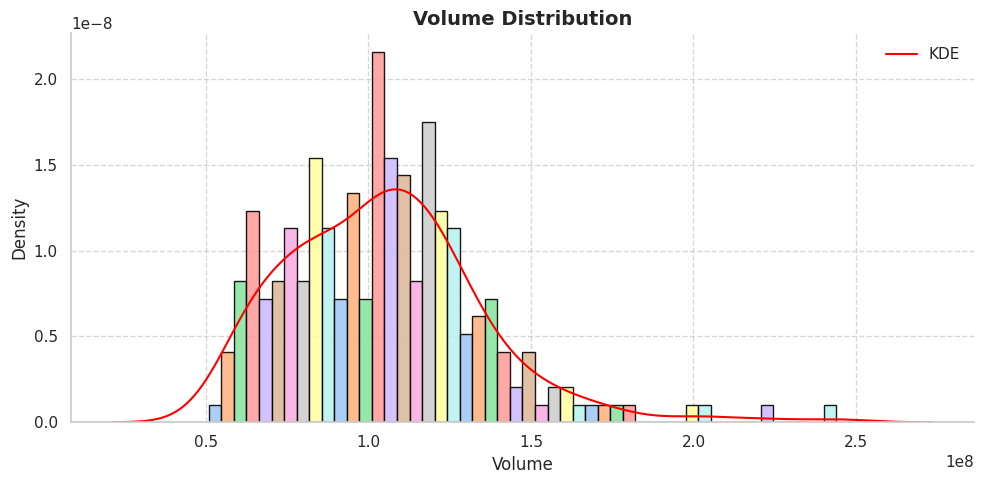

In [214]:
# Volume Distribution
num_bins = 50

# Compute histogram using density=True
counts, bins = np.histogram(df['Volume'], bins=num_bins, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Random pastel colors
colors = sns.color_palette("pastel", num_bins)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 5))

# Draw bars with density heights
for i in range(num_bins):
    ax.bar(
        bin_centers[i],
        counts[i],
        width=(bins[1] - bins[0]),
        color=colors[i % len(colors)],
        edgecolor='black',
        alpha=0.9
    )

# KDE line
sns.kdeplot(df['Volume'], ax=ax, color='red', linewidth=1.5, label='KDE')

# Customize plot
ax.set_title('Volume Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Volume')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.8)
sns.despine()

plt.tight_layout()
plt.show()

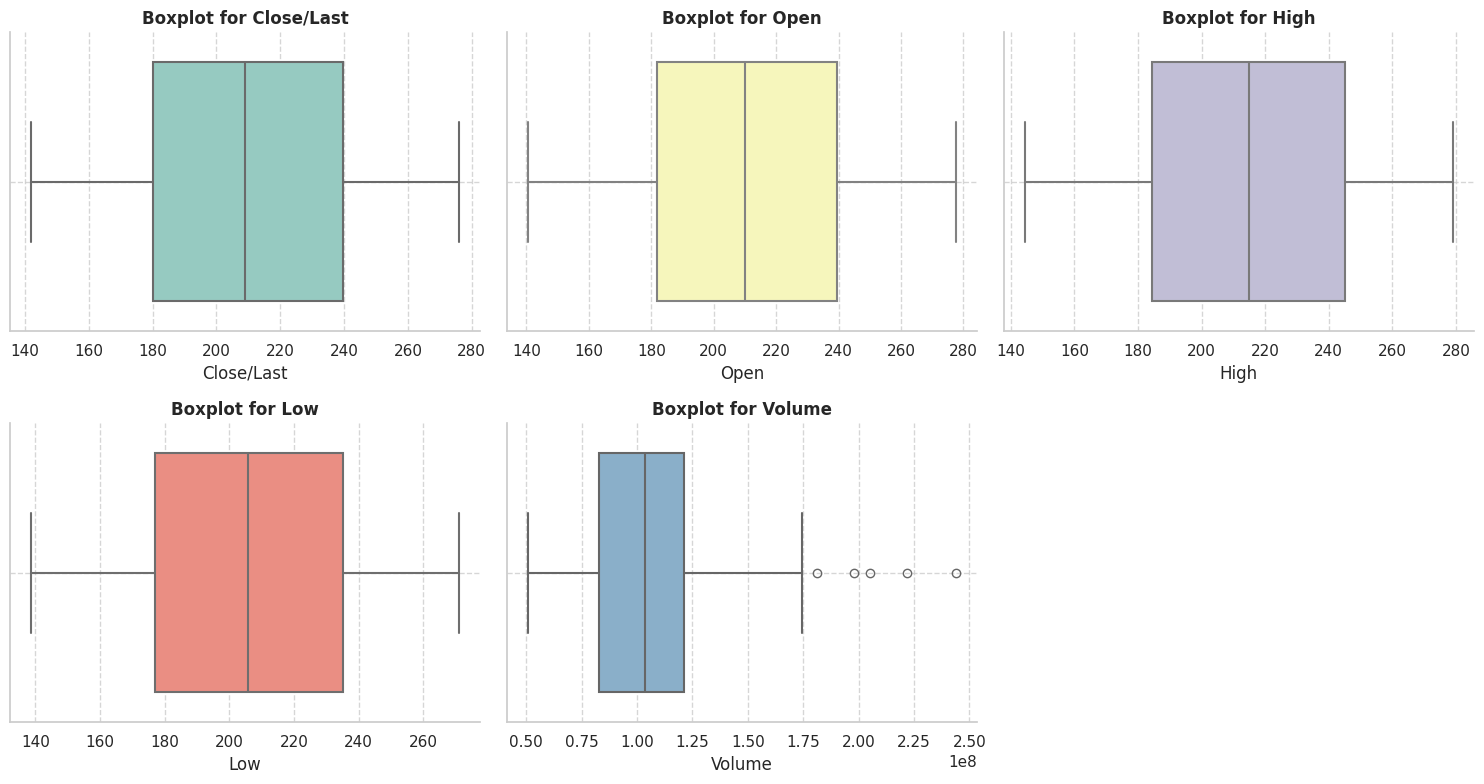

In [215]:
# Boxplots for Outliers
price_cols_with_volume = price_cols + ['Volume']
palette = sns.color_palette("Set3", len(price_cols_with_volume))

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(price_cols_with_volume):
    sns.boxplot(x=df[col], ax=axes[i], color=palette[i], linewidth=1.5)
    axes[i].set_title(f'Boxplot for {col}', fontsize=12, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.8)

# Hide any unused subplot (in case number of plots < subplots)
for j in range(len(price_cols_with_volume), len(axes)):
    fig.delaxes(axes[j])  # Clean up extra subplot

sns.despine()
plt.tight_layout()
plt.show()


# 3. Time Series Trends

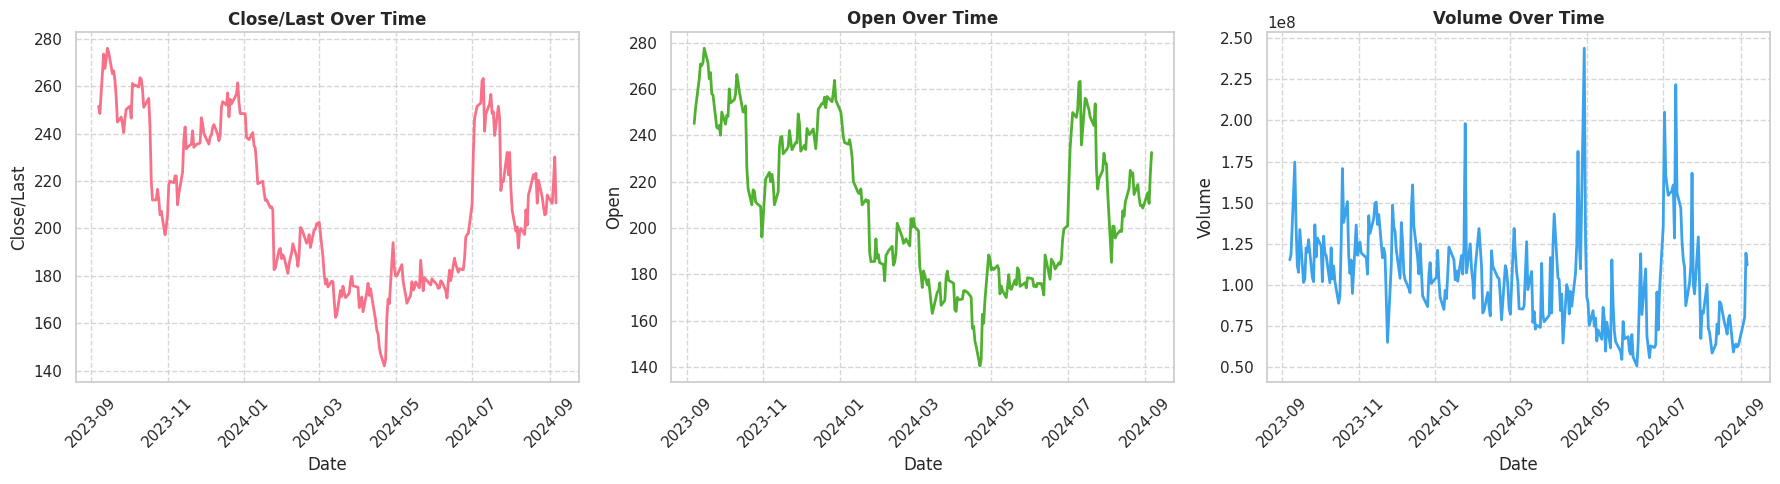

In [216]:
# Line plots
cols = ['Close/Last', 'Open', 'Volume']
colors = sns.color_palette("husl", len(cols))  # Vibrant distinct colors

# Create subplots in one row
fig, axes = plt.subplots(1, len(cols), figsize=(18, 5), sharex=True)

for i, col in enumerate(cols):
    axes[i].plot(df['Date'], df[col], color=colors[i], linewidth=2)
    axes[i].set_title(f'{col} Over Time', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.8)

# Adjust layout
plt.tight_layout()
plt.show()


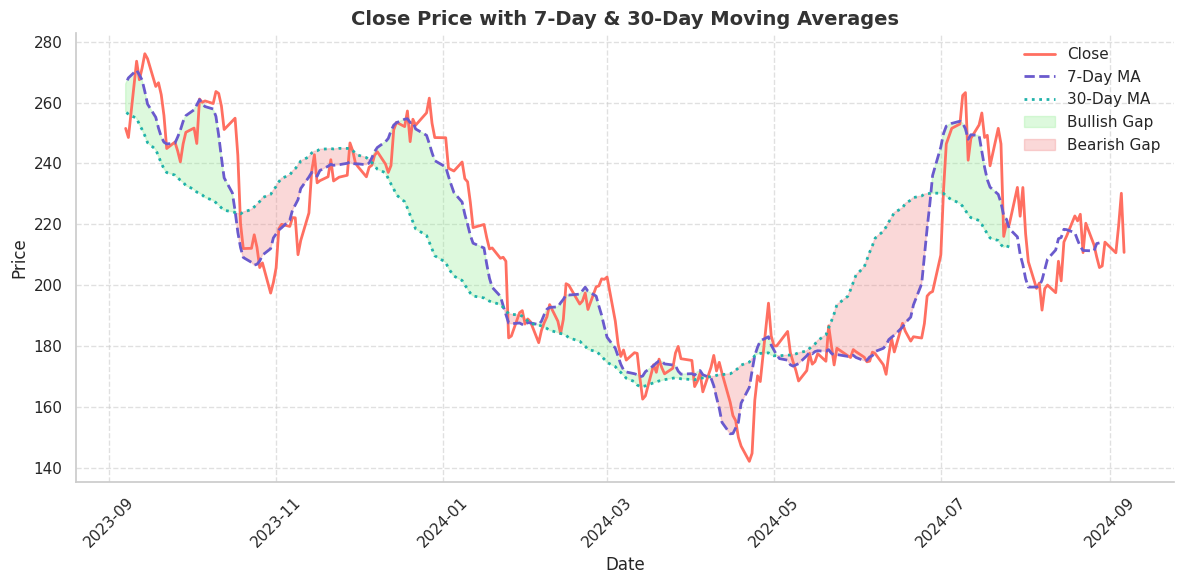

In [217]:
# Rolling averages (7-day & 30-day)
df['Close_7d'] = df['Close/Last'].rolling(window=7).mean()
df['Close_30d'] = df['Close/Last'].rolling(window=30).mean()

# Define more vibrant custom colors
close_color = "#FF6F61"    # Coral
ma7_color = "#6A5ACD"      # Slate Blue
ma30_color = "#20B2AA"     # Light Sea Green
gap_color = "#FFD700"      # Gold

# Create the plot with custom background color
fig, ax = plt.subplots(figsize=(12, 6))
# fig.patch.set_facecolor('#f0f0f5')  # Light gray background
# ax.set_facecolor('#fafafa')         # Slightly off-white axes area

# Plot lines
ax.plot(df['Date'], df['Close/Last'], label='Close', color=close_color, linewidth=2)
ax.plot(df['Date'], df['Close_7d'], label='7-Day MA', color=ma7_color, linestyle='--', linewidth=2)
ax.plot(df['Date'], df['Close_30d'], label='30-Day MA', color=ma30_color, linestyle=':', linewidth=2)

# Fill between MAs with attractive color
ax.fill_between(df['Date'], df['Close_7d'], df['Close_30d'],
                where=(df['Close_7d'] > df['Close_30d']),
                interpolate=True, color='lightgreen', alpha=0.3, label='Bullish Gap')

ax.fill_between(df['Date'], df['Close_7d'], df['Close_30d'],
                where=(df['Close_7d'] <= df['Close_30d']),
                interpolate=True, color='lightcoral', alpha=0.3, label='Bearish Gap')

# Customizations
ax.set_title('Close Price with 7-Day & 30-Day Moving Averages',
             fontsize=14, fontweight='bold', color='#333333')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()


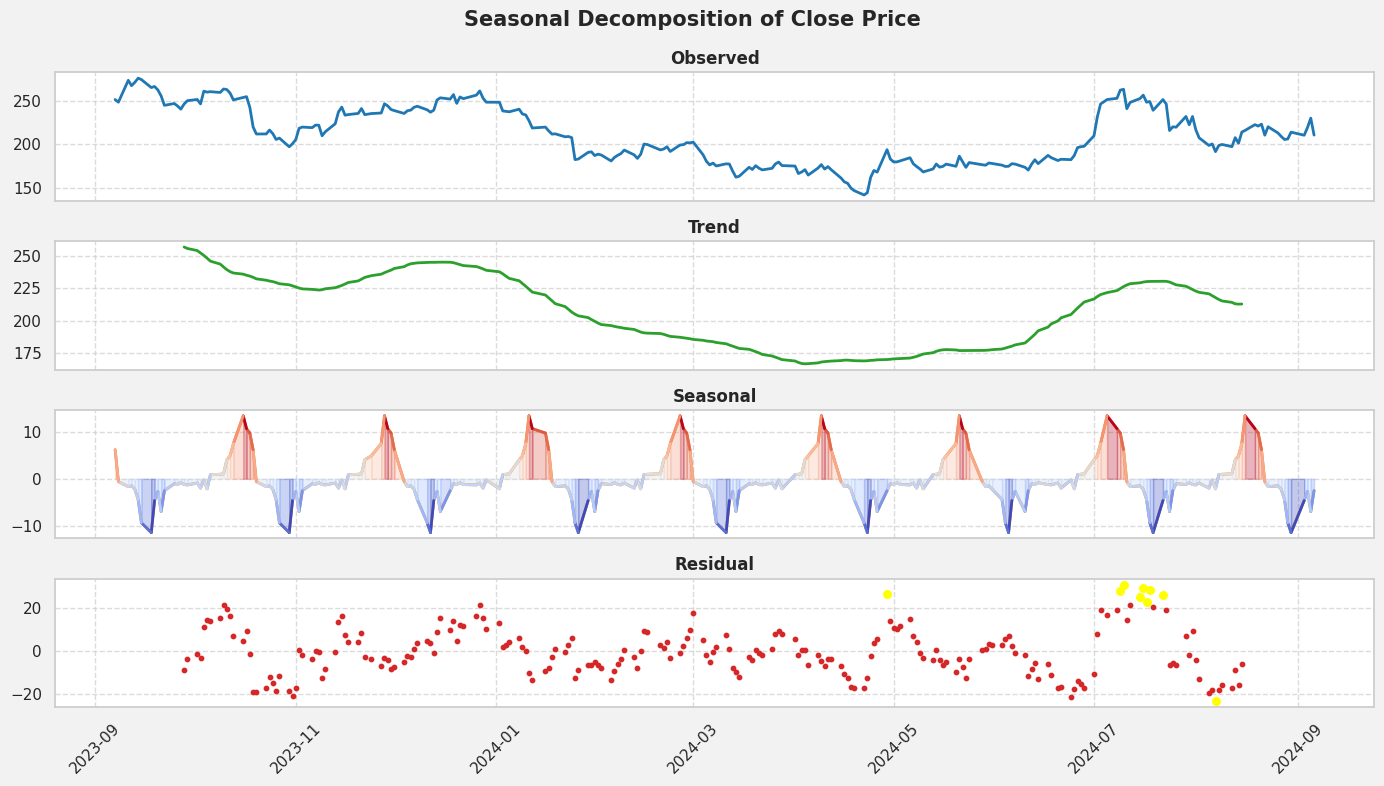

In [218]:
# Seasonal Decomposition

# Perform decomposition
decomposition = seasonal_decompose(df['Close/Last'], model='additive', period=30)

# Extract components
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Define colors
colors = {
    'observed': '#1f77b4',  # Blue
    'trend': '#2ca02c',     # Green
    'seasonal': '#ff7f0e',  # Orange
    'residual': '#d62728'   # Red
}

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
fig.patch.set_facecolor('#f2f2f2')

# Plot each component with colors and labels
axes[0].plot(df['Date'], observed, color=colors['observed'], label='Observed', linewidth=2)
axes[0].set_title('Observed', fontsize=12, weight='bold')
axes[0].grid(True, linestyle='--', alpha=0.7)

axes[1].plot(df['Date'], trend, color=colors['trend'], label='Trend', linewidth=2)
axes[1].set_title('Trend', fontsize=12, weight='bold')
axes[1].grid(True, linestyle='--', alpha=0.7)

axes[2].plot(df['Date'], seasonal, color=colors['seasonal'], label='Seasonal', linewidth=2)
axes[2].set_title('Seasonal', fontsize=12, weight='bold')
axes[2].grid(True, linestyle='--', alpha=0.7)

axes[3].scatter(df['Date'], residual, color=colors['residual'], label='Residual', s=10)
axes[3].set_title('Residual', fontsize=12, weight='bold')
axes[3].grid(True, linestyle='--', alpha=0.7)


# Highlight residuals greater than 2 standard deviations from the mean
threshold = 2 * residual.std()
anomalies = residual[abs(residual) > threshold]
axes[3].scatter(df['Date'][anomalies.index], anomalies, color='yellow', label='Anomalies', s=30, zorder=5)

# Apply color gradient to seasonal component (gradient based on date)
norm = plt.Normalize(seasonal.min(), seasonal.max())  # Normalize the seasonal component
cmap = cm.coolwarm  # Choose a color map (can be 'plasma', 'coolwarm', etc.)

# Plot gradient line + shaded area under seasonal component
for i in range(1, len(seasonal)):
    x = [df['Date'][i-1], df['Date'][i]]
    y = [seasonal[i-1], seasonal[i]]
    color = cmap(norm(seasonal[i]))

    # Line segment
    axes[2].plot(x, y, color=color, lw=2)
    # Shaded area (fill between line and y=0)
    axes[2].fill_between(x, y, [0, 0], color=color, alpha=0.3)

# Customize x-axis
for ax in axes:
    ax.label_outer()
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Seasonal Decomposition of Close Price', fontsize=15, weight='bold')
plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 4. Correlation Analysis

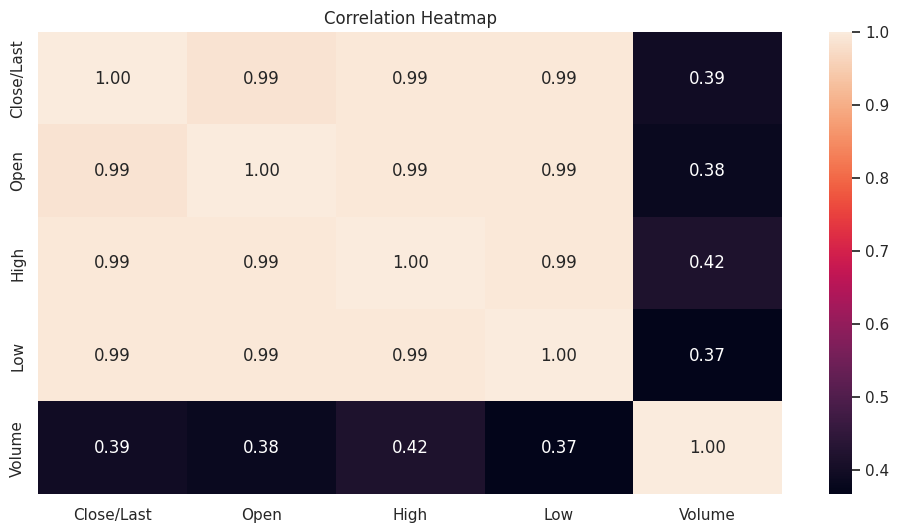

In [219]:
# Pearson correlation
corr_matrix = df[['Close/Last', 'Open', 'High', 'Low', 'Volume']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='rocket', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 5. Outlier Detection

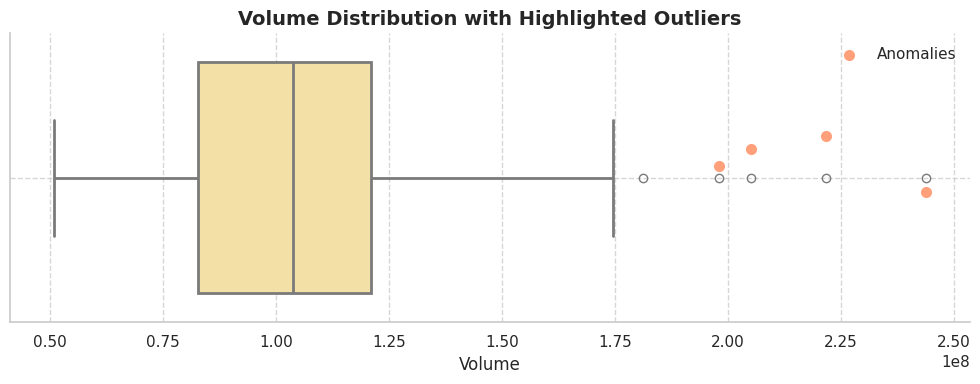

In [220]:
# Detect outliers using Z-score
z_scores = np.abs(zscore(df[['Close/Last', 'Open', 'High', 'Low', 'Volume']]))
outliers = (z_scores > 3).any(axis=1)
df_outliers = df[outliers]

# Use light yellow-orange theme
base_color = '#FFE699'        # soft pastel yellow
highlight_color = '#FFA07A'   # light salmon-orange

# Plot Volume Boxplot with highlighted outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Volume'], color=base_color, linewidth=2)

# Overlay dots for detected outliers
sns.stripplot(x=df_outliers['Volume'], color=highlight_color, size=8, jitter=0.15, label="Anomalies", zorder=10)

plt.title("Volume Distribution with Highlighted Outliers", fontsize=14, fontweight='bold')
plt.xlabel("Volume")
plt.legend()
sns.despine()
plt.grid(True, linestyle="--", alpha=0.8)
plt.tight_layout()
plt.show()

# 6. Technical Indicators


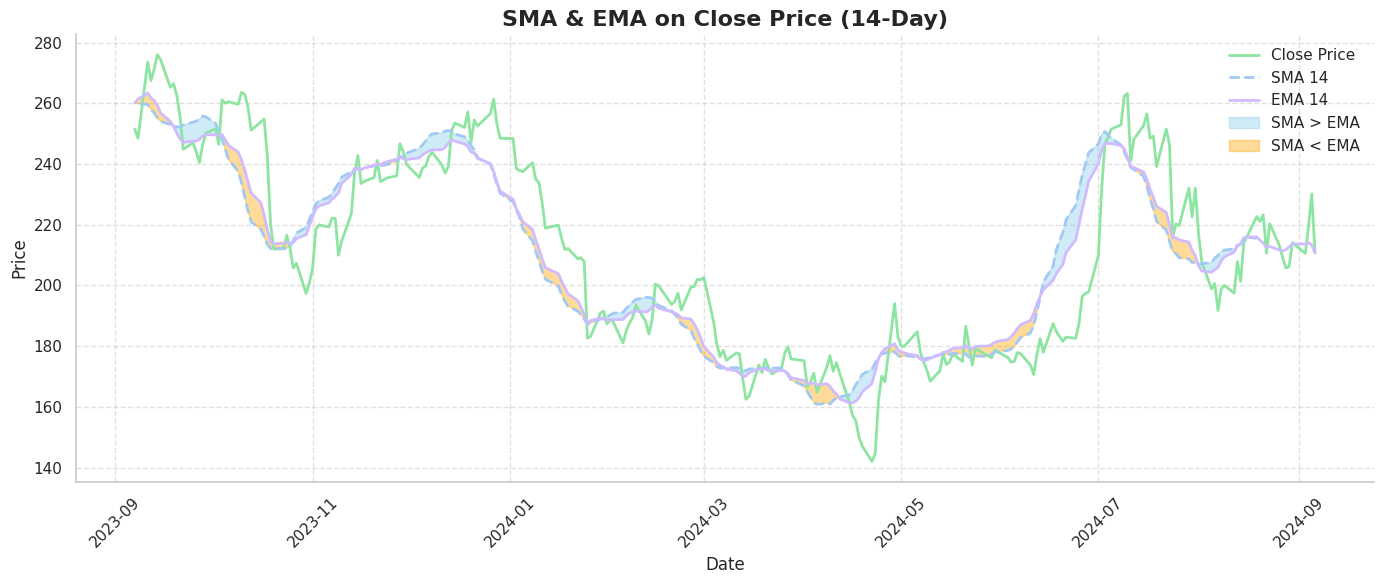

In [221]:
# SMA (Simple Moving Average)
df['SMA_14'] = df['Close/Last'].rolling(window=14).mean()

# EMA (Exponential Moving Average)
df['EMA_14'] = df['Close/Last'].ewm(span=14, adjust=False).mean()

# Define new gentle color scheme
close_color = sns.color_palette("pastel")[2]   # Light orange
sma_color = sns.color_palette("pastel")[0]     # Soft blue
ema_color = sns.color_palette("pastel")[4]     # Light violet

# Plot setup
plt.figure(figsize=(14, 6))

# Plot each line
plt.plot(df['Date'], df['Close/Last'], label='Close Price', color=close_color, linewidth=2)
plt.plot(df['Date'], df['SMA_14'], label='SMA 14', color=sma_color, linestyle='--', linewidth=2)
plt.plot(df['Date'], df['EMA_14'], label='EMA 14', color=ema_color, linestyle='-', linewidth=2)

# Fill the area between SMA and EMA
plt.fill_between(df['Date'], df['SMA_14'], df['EMA_14'], where=(df['SMA_14'] > df['EMA_14']),
                 color='skyblue', alpha=0.4, label='SMA > EMA', interpolate=True)
plt.fill_between(df['Date'], df['SMA_14'], df['EMA_14'], where=(df['SMA_14'] < df['EMA_14']),
                 color='orange', alpha=0.4, label='SMA < EMA', interpolate=True)

# Formatting
plt.title('SMA & EMA on Close Price (14-Day)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [222]:
# RSI (Relative Strength Index)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['Close/Last'])

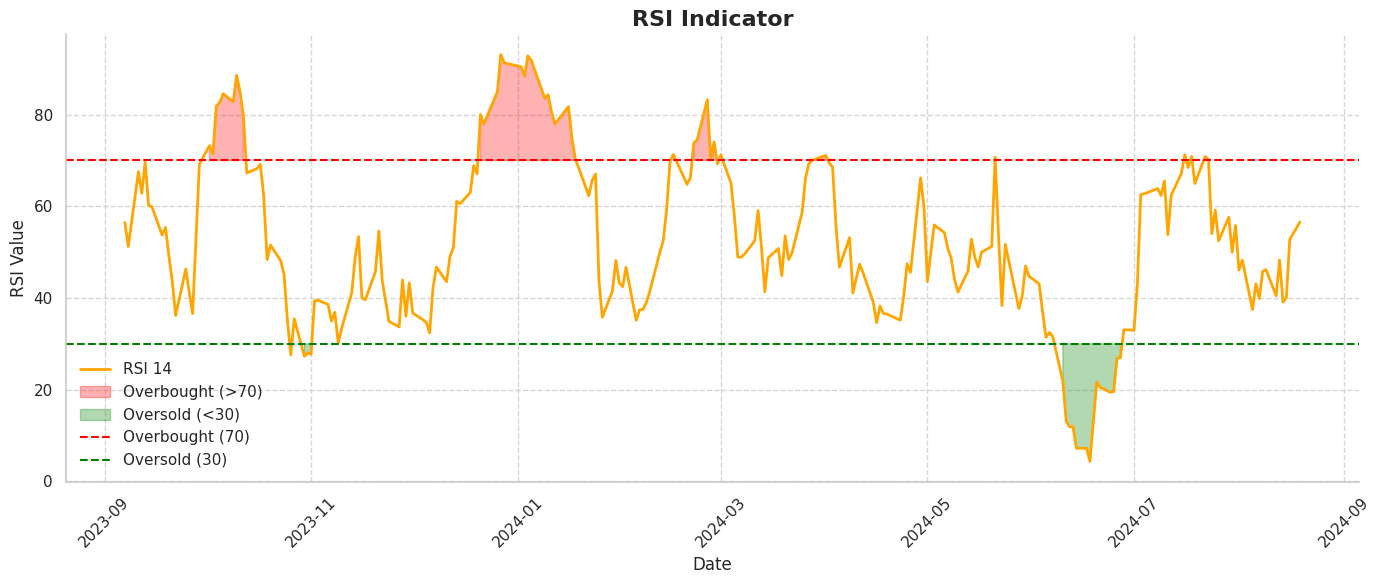

In [223]:
# Define colors
rsi_color = 'orange'
overbought_color = 'red'
oversold_color = 'green'
highlight_color = 'skyblue'

# Plot setup
plt.figure(figsize=(14, 6))

# Plot RSI line
plt.plot(df['Date'], df['RSI_14'], color=rsi_color, label='RSI 14', linewidth=2)

# Highlight areas above 70 (overbought) and below 30 (oversold)
plt.fill_between(df['Date'], df['RSI_14'], 70, where=(df['RSI_14'] > 70), color=overbought_color, alpha=0.3, label='Overbought (>70)')
plt.fill_between(df['Date'], df['RSI_14'], 30, where=(df['RSI_14'] < 30), color=oversold_color, alpha=0.3, label='Oversold (<30)')

# Add horizontal lines at 70 and 30
plt.axhline(70, color=overbought_color, linestyle='--', label='Overbought (70)')
plt.axhline(30, color=oversold_color, linestyle='--', label='Oversold (30)')

# Customize plot
plt.title('RSI Indicator', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('RSI Value', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.8)

# Display the legend and finalize plot
plt.legend(loc='lower left')
sns.despine()
plt.tight_layout()
plt.show()